In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### Fetching California Housing Prices data 

In [2]:
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Cleaning and Preparing the data

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [10]:
housing_test = strat_test_set.drop("median_house_value", axis=1) # drop labels for testing set
housing_labels_test = strat_test_set["median_house_value"].copy()

Removing text attributes before replacing NA values by the median

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [12]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [13]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [14]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155,    3.     ])

In [15]:
X = imputer.transform(housing_num)

In [16]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

Treating categorical attributes with the one hot encoder

In [17]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [18]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [20]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241


In [30]:
housing_extra_attribs.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'income_cat', 'rooms_per_household',
       'population_per_household'],
      dtype='object')

### Transformation pipelines

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [22]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [23]:
housing_prepared.shape

(16512, 17)

In [24]:
type(housing_prepared)

numpy.ndarray

### Select and Train Models 

Let's try some SVM models, more precisely, SVR models to predict our housing median prices.

We have to choose between 4 differents kernels : linear, rbf, polynomial or sigmoid. Let's try first with the rbf which have the advantage to handle non-linear data. This could be helpful for the learning as some of our columns such as longitude, latitude, housing median age or population could have relationship non-linear.

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score


Evaluating SVR with C=0.1

Evaluating SVR with C=1

Evaluating SVR with C=10

Evaluating SVR with C=100

Evaluating SVR with C=1000

Evaluating SVR with C=10000


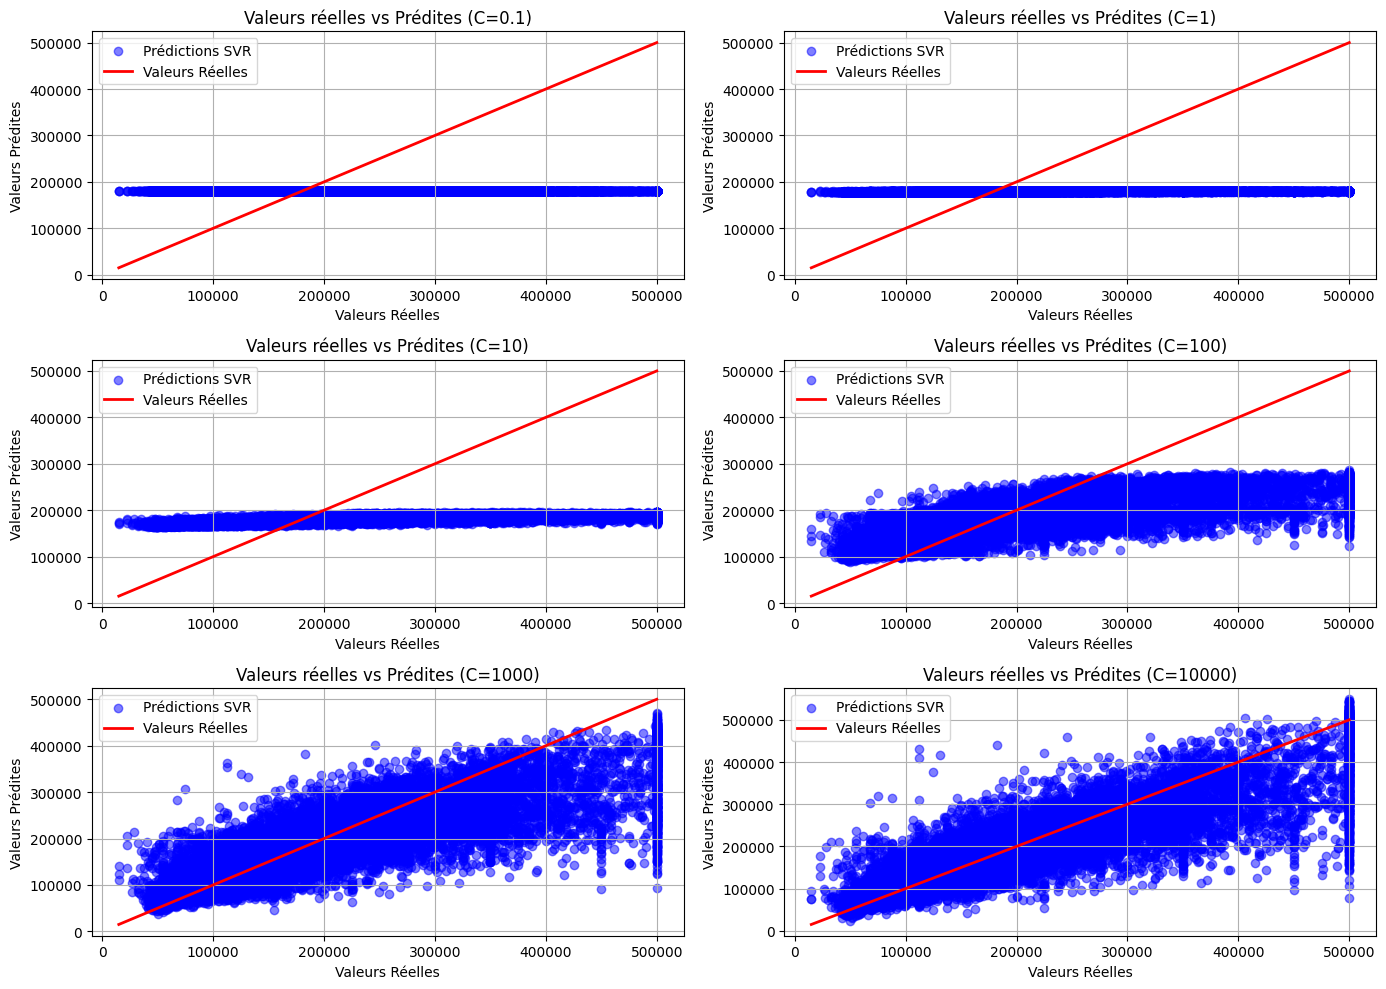

In [40]:
C_values = [0.1, 1, 10, 100, 1000, 10000]

rmse_scores = []
mae_scores = []
r2_scores = []

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.ravel()

for idx, C in enumerate(C_values):
    print(f"\nEvaluating SVR with C={C}")
    
    svr_rbf = SVR(kernel="rbf", C=C)
    
    svr_rbf.fit(housing_prepared, housing_labels)
    
    housing_predictions_rbf = svr_rbf.predict(housing_prepared)

    svr_rbf_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions_rbf))
    svr_rbf_mae = mean_absolute_error(housing_labels, housing_predictions_rbf)
    svr_r2 = r2_score(housing_labels, housing_predictions_rbf)
    
    rmse_scores.append(svr_rbf_rmse)
    mae_scores.append(svr_rbf_mae)
    r2_scores.append(svr_r2)

    axs[idx].scatter(housing_labels, housing_predictions_rbf, color='blue', label='SVR RBF kernel Predicitions', alpha=0.5)
    axs[idx].plot([housing_labels.min(), housing_labels.max()], [housing_labels.min(), housing_labels.max()], color='red', lw=2, label='Real Values')
    axs[idx].set_title(f"Real Values vs Predicted Values (C={C})")
    axs[idx].set_xlabel('Real Values')
    axs[idx].set_ylabel('Predicted Values')
    axs[idx].legend()
    axs[idx].grid(True)

    print(f"RMSE: {svr_rbf_rmse:.3f}")
    print(f"MAE: {svr_rbf_mae:.3f}")
    print(f"R²: {svr_r2:.3f}")

    if C == 1000:
        scores = cross_val_score(svr_rbf, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
        svm_rmse_scores = np.sqrt(-scores)

plt.tight_layout()

plt.show()


The first predictions of our SVR are terrible as they seem almost constant while the real values seem linear. Not surprising as we saw in the first lab with the correlation matrix that the biggest correlation by far with the median_house_value was the median_income with 0.68 correlation and median_income is a linear data.
In our case, it seems the model is underfitting. We can try to change some hyperparameters in the model by changing the C value which is by default to 1. 
The hyperparameter C in the SVR method controls how much penalty is applied for errors or deviations in the training data to make it more flexible to handle extraordinary values. A low C prevent overfitting but can lead to some undertting if the regularization is too high. On the contrary, a higher C can cause overfitting making it less tolerant for deviations in the training data. 

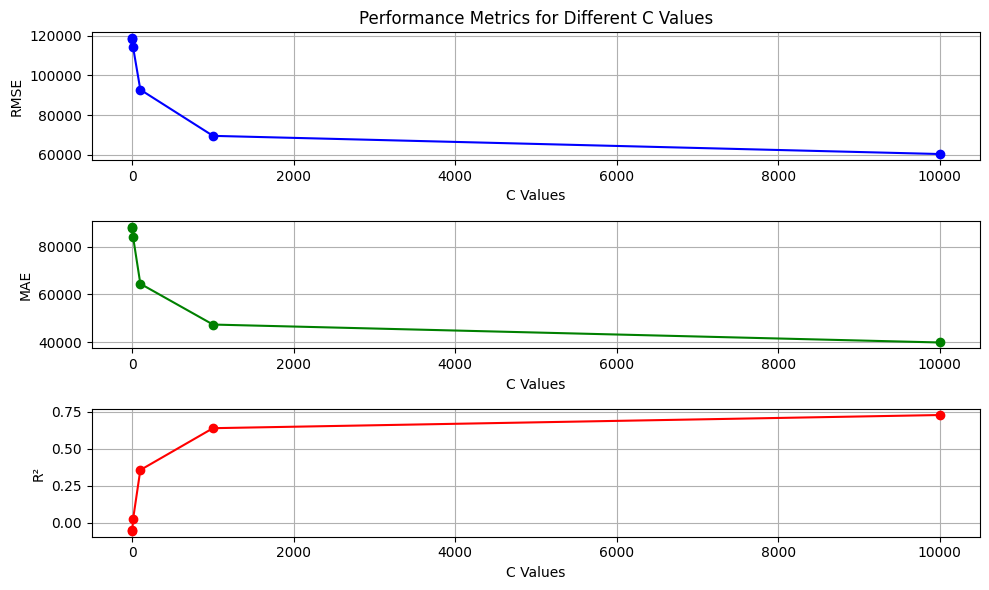

In [41]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(C_values, rmse_scores, marker='o', color='blue', label='RMSE')
plt.title('Performance Metrics for Different C Values')
plt.xlabel('C Values')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(C_values, mae_scores, marker='o', color='green', label='MAE')
plt.xlabel('C Values')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(C_values, r2_scores, marker='o', color='red', label='R²')
plt.xlabel('C Values')
plt.ylabel('R²')
plt.grid(True)

plt.tight_layout()
plt.show()

We can also try some Cross-Validation Scores, not on all as it takes quite some time but on on of the best result with C=1000 for instance that we previously stocked in variables to avoid computing it again. 

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(svm_rmse_scores)

Now let's try with linear kernel

In [ ]:
C_values = [0.1, 1, 10, 100, 1000, 10000]

rmse_linear_scores = []
mae_linear_scores = []
r2_linear_scores = []

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.ravel()

for idx, C in enumerate(C_values):
    print(f"\nEvaluating SVR with C={C}")

    svr_linear = SVR(kernel="linear", C=C)

    svr_linear.fit(housing_prepared, housing_labels)

    housing_predictions_linear = svr_linear.predict(housing_prepared)

    svr_linear_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions_linear))
    svr_linear_mae = mean_absolute_error(housing_labels, housing_predictions_linear)
    r2 = r2_score(housing_labels, housing_predictions_linear)

    rmse_linear_scores.append(svr_linear_rmse)
    mae_linear_scores.append(svr_linear_mae)
    r2_linear_scores.append(r2)

    axs[idx].scatter(housing_labels, housing_predictions_linear, color='blue', label='SVR Linear kernel Predictions', alpha=0.5)
    axs[idx].plot([housing_labels.min(), housing_labels.max()], [housing_labels.min(), housing_labels.max()], color='red', lw=2, label='Real Values')
    axs[idx].set_title(f"Real Values vs Predicted Values (C={C})")
    axs[idx].set_xlabel('Real Values')
    axs[idx].set_ylabel('Predicted Values')
    axs[idx].legend()
    axs[idx].grid(True)

    print(f"RMSE: {svr_rbf_rmse:.3f}")
    print(f"MAE: {svr_rbf_mae:.3f}")
    print(f"R²: {svr_r2:.3f}")

    if C == 1000:
        scores = cross_val_score(svr_rbf, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
        svm_rmse_scores = np.sqrt(-scores)

plt.tight_layout()

plt.show()

In [ ]:

# Plot the RMSE, MAE, and R² metrics for different C values
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(C_values, rmse_scores, marker='o', color='blue', label='RMSE')
plt.title('Performance Metrics for Different C Values')
plt.xlabel('C Values')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(C_values, mae_scores, marker='o', color='green', label='MAE')
plt.xlabel('C Values')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(C_values, r2_scores, marker='o', color='red', label='R²')
plt.xlabel('C Values')
plt.ylabel('R²')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
display_scores(svm_rmse_scores)

Let's try what we have seen in the lab with the linear regression, the decision tree regressor and the random forest regressor to compare all the rmse results with a boxplot

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
linear_housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, linear_housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_labels, linear_housing_predictions)
lin_r2 = r2_score(housing_labels, linear_housing_predictions)

In [ ]:
print("mse : ", lin_mse)
print("rmse : ", lin_rmse)
print("mae : ", lin_mae)
print("r2 : ", lin_r2)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Now the Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
tree_housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(housing_labels, tree_housing_predictions)
tree_r2 = r2_score(housing_labels, tree_housing_predictions)

In [ ]:
print("mse : ", tree_mse)
print("rmse : ", tree_rmse)
print("mae : ", tree_mae)
print("r2 : ", tree_r2)

In [ ]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

An then the Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_mae = mean_absolute_error(housing_labels, tree_housing_predictions)
forest_r2 = r2_score(housing_labels, tree_housing_predictions)

In [ ]:
print("mse : ", forest_mse)
print("rmse : ", forest_rmse)
print("mae : ", forest_mae)
print("r2 : ", forest_r2)

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Now let's create a boxplot to compare the rmse between the different models : random forest, linear_regression, svr, and decision_tree_regressor

In [26]:
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR

In [31]:
svr_rbf = SVR(kernel="rbf")
svr_rbf.fit(housing_prepared, housing_labels)
housing_predictions_rbf = svr_rbf.predict(housing_prepared)
svr_rbf_mse = mean_squared_error(housing_labels, housing_predictions_rbf)
svr_rbf_rmse = np.sqrt(svr_rbf_mse)
svr_rbf_rmse

118451.153930123

In [32]:
from sklearn.metrics import mean_absolute_error
svr_rbf_mae = mean_absolute_error(housing_labels, housing_predictions_rbf)
svr_rbf_mae


87920.18370536316

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(housing_labels,housing_predictions_rbf)

In [34]:
r2

-0.048162065030392665

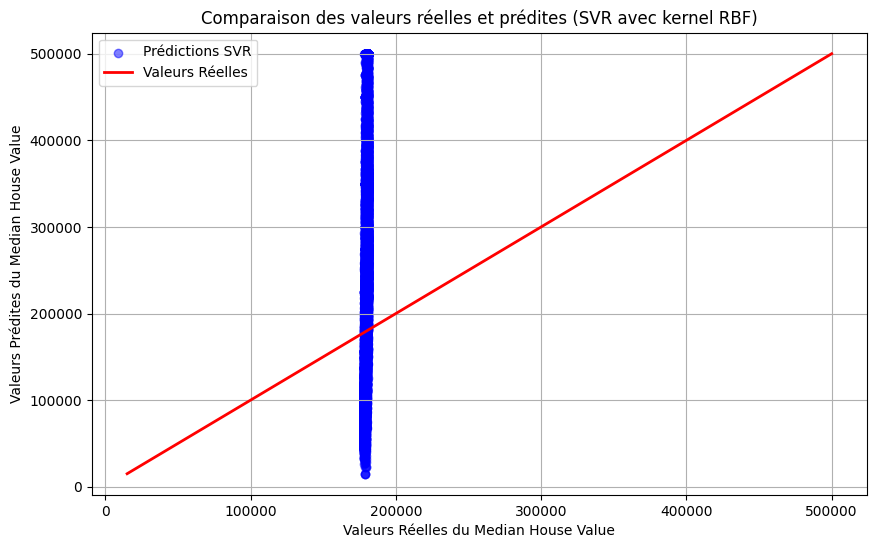

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(housing_predictions, housing_labels, color='blue', label='Prédictions SVR', alpha=0.5)
plt.plot([housing_labels.min(), housing_labels.max()], [housing_labels.min(), housing_labels.max()], color='red', lw=2, label='Valeurs Réelles')
plt.title("Comparaison des valeurs réelles et prédites (SVR avec kernel RBF)")
plt.xlabel('Valeurs Réelles du Median House Value')
plt.ylabel('Valeurs Prédites du Median House Value')
plt.legend()
plt.grid(True)
plt.show()

Cross-Validation

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svr_rbf, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

In [50]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(svm_rmse_scores)

Scores: [116628.19183878 119988.26365356 113823.78366263 120271.03189229
 114581.92489539 122665.05912251 119753.16461411 118174.92428728
 120129.13952467 118707.9580594 ]
Mean: 118472.3441550637
Standard deviation: 2603.593039791196


with linear kernel

In [28]:
svm_reg_lin = SVR(kernel="linear")
svm_reg_lin.fit(housing_prepared, housing_labels)
housing_predictions_lin = svm_reg_lin.predict(housing_prepared)
svm_mse_lin = mean_squared_error(housing_labels, housing_predictions_lin)
svm_rmse_lin = np.sqrt(svm_mse_lin)
svm_rmse_lin

106873.526604078

In [47]:
svm_mae_lin = mean_absolute_error(housing_labels, housing_predictions)
svm_mae_lin

87920.18370536316

Now let's try the cross validation as well with the linear kernel

In [41]:
scores_lin = cross_val_score(svm_reg_lin, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores_lin = np.sqrt(-scores)

NameError: name 'cross_val_score' is not defined

In [41]:
display_scores(svm_rmse_scores_lin)

Scores: [106846.91418486 108840.55721006 103122.02433423 109649.5401006
 103796.57205905 112219.65143015 109351.47147536 107877.83853403
 109166.01514235 108053.90140047]
Mean: 107892.44858711655
Standard deviation: 2590.6419916301356


Wether using kernel linear or rbf, the rmse is still huge, the model might be underfitting, to try to correct that let's change the c value in the svr method which is by default to 1.

In [42]:
svm_reg = SVR(kernel="rbf", C=10)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

114317.81510793976

In [43]:
svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

84015.8649253825

In [44]:
scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

In [45]:
display_scores(svm_rmse_scores)

Scores: [112984.08196022 116112.60784158 109986.22420648 116488.50441569
 110826.84302586 119080.08183354 116081.83665308 114405.16499903
 116404.99565896 114952.56245846]
Mean: 114732.29030529011
Standard deviation: 2636.3137008432022


slightly better but not so much, let's try again with a c=100 now

In [46]:
svm_reg = SVR(kernel="rbf", C=100)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

92807.51397858899

In [47]:
svm_reg = SVR(kernel="rbf", C=1000)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

69455.87685031301

In [48]:
svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

47444.52550615006

In [50]:
scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

In [51]:
display_scores(svm_rmse_scores)

Scores: [72201.62369675 68394.25664066 65163.46631075 72457.203971
 66999.77435739 73985.38073212 73076.6049665  69700.98557851
 69752.23314738 71183.66324766]
Mean: 70291.51926487243
Standard deviation: 2681.559278300358


ValueError: x and y must be the same size

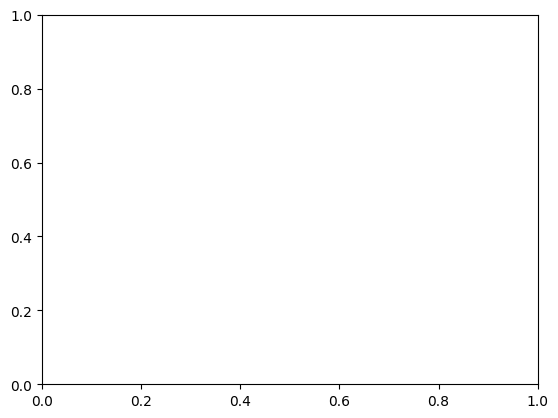

In [54]:
housing_prepared_grid = np.arange(np.min(housing_prepared),np.max(housing_prepared),0.01)
housing_prepared_grid = housing_prepared_grid.reshape((len(housing_prepared_grid),1))
plt.scatter(housing_prepared,housing_labels,color='red')
plt.plot(housing_prepared_grid, svm_reg.predict(housing_prepared_grid),color='blue')
plt.title('SVR for california housing prices prediction')
plt.xlabel('housing features')
plt.ylabel('housing price')
plt.show()

In [34]:
print(housing_prepared.shape)
print(housing_pr)
print(housing_labels.shape)
print(housing_labels_test.shape)

(16512, 17)
(16512,)
(4128,)
